In [2]:
# import obspy
import obspy
from obspy.taup import TauPyModel
from obspy.core import UTCDateTime
from obspy.geodetics import locations2degrees

# import the two different clients, and differentiate between names
from obspy.clients.fdsn import Client as Client 
from obspy.clients.syngine import Client as synClient

# other packages
import matplotlib.pyplot as plt
import numpy as np

# matplotlib magic
%matplotlib inline

In [3]:
# set an observatory to use for later analysis
network = "IU"
station = "ANMO"

# get a real station.
iris = Client("IRIS")
ANMO = iris.get_stations(network=network, 
                           station=station, 
                           format="text")[0][0]

print(ANMO)

Station ANMO (Albuquerque, New Mexico, USA)
	Station Code: ANMO
	Channel Count: None/None (Selected/Total)
	1989-08-29T00:00:00.000000Z - 2000-10-19T16:00:00.000000Z
	Access: None 
	Latitude: 34.95, Longitude: -106.46, Elevation: 1850.0 m
	Available Channels:



We can load all the current models that are available on Syngine, and preview some basic information about them.

In [4]:
# initialize the syngine client
client = synClient()

# load the models
models = client.get_available_models()

# print the models
models

{'ak135f_5s': {'components': 'vertical and horizontal',
  'description': 'ak135 with density & Q of Montagner & Kennet(1996)',
  'max_sampling_period': '1.278000',
  'default_components': 'ZNE',
  'max_event_depth': 750000,
  'length': 3904.29,
  'min_period': 5.125,
  'max_period': '~100',
  'default_dt': '0.25'},
 'prem_a_2s': {'components': 'vertical and horizontal',
  'description': 'anisotropic PREM',
  'max_sampling_period': '0.512260',
  'default_components': 'ZNE',
  'max_event_depth': 750000,
  'length': 3609.89347171399,
  'min_period': 2.09999990463257,
  'max_period': '~100',
  'default_dt': '0.1'},
 'prem_i_2s': {'components': 'vertical and horizontal',
  'description': 'isotropic PREM',
  'max_sampling_period': '0.512260',
  'default_components': 'ZNE',
  'max_event_depth': 750000,
  'length': 3609.89347171448,
  'min_period': 2.09999990463257,
  'max_period': '~100',
  'default_dt': '0.1'},
 'ak135f_2s': {'components': 'vertical and horizontal',
  'description': 'ak135 w

We can now select the event we want to examine. We'll use [the largest earthquake so far in 2021](https://earthquake.usgs.gov/earthquakes/eventpage/us7000dflf/executive): 

2021-03-04 19:28:33 M8.1 Kermadec Islands, New Zealand 

- 29.723°S, 177.279°W

- 28.9 km depth

In [58]:
# load basic event information
event_dict = {"lat": -29.723,
              "lon": 177.279,
              "depth": 28.9}

# load the event ID for later
event_id = "GCMT:C202103041928A"

# set the start and endtime, add a significant delay
starttime = UTCDateTime("2021-03-04T19:41:33.000000Z")
endtime = UTCDateTime("2021-03-04T19:56:00.200000Z")

Load the [TauPyModel](https://docs.obspy.org/packages/obspy.taup.html) which was dervied from [Crotwell *et al*, 1999](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/70/2/154/142385/The-TauP-Toolkit-Flexible-Seismic-Travel-time-and?redirectedFrom=fulltext).

Ships with 13 possible models.

In [6]:
# set the model to use and intialize it
tauModel = "ak135"
model = TauPyModel(tauModel)

Now that we have a model, we can [estimate the travel times](https://docs.obspy.org/sphinx3/packages/autogen/obspy.taup.tau.TauPyModel.get_travel_times_geo.html) for each arriving ray from our event to our station. This returns a chronological list of arrivals.

In [7]:
# get the travel times, use the station object and our event dictionary
travel_time = model.get_travel_times_geo(source_depth_in_km=event_dict["depth"], 
                                         source_latitude_in_deg=event_dict["lat"],
                                         source_longitude_in_deg=event_dict["lon"], 
                                         receiver_latitude_in_deg=ANMO.latitude,
                                         receiver_longitude_in_deg=ANMO.longitude)

# print the travel times
print(travel_time)

31 arrivals
	P phase arrival at 807.103 seconds
	PcP phase arrival at 807.240 seconds
	pP phase arrival at 816.443 seconds
	sP phase arrival at 819.778 seconds
	PP phase arrival at 1041.580 seconds
	PKiKP phase arrival at 1084.142 seconds
	pPKiKP phase arrival at 1093.733 seconds
	sPKiKP phase arrival at 1097.017 seconds
	SKiKP phase arrival at 1296.849 seconds
	SKS phase arrival at 1441.854 seconds
	pSKS phase arrival at 1454.454 seconds
	sSKS phase arrival at 1457.809 seconds
	SKKS phase arrival at 1467.663 seconds
	S phase arrival at 1486.241 seconds
	ScS phase arrival at 1486.706 seconds
	pS phase arrival at 1498.275 seconds
	sS phase arrival at 1501.788 seconds
	SP phase arrival at 1566.264 seconds
	PS phase arrival at 1569.954 seconds
	PKKP phase arrival at 1810.327 seconds
	PKIKKIKP phase arrival at 1811.478 seconds
	SS phase arrival at 1880.493 seconds
	SKIKKIKP phase arrival at 2024.164 seconds
	PKIKKIKS phase arrival at 2027.448 seconds
	SKKP phase arrival at 2027.857 seconds

We can also visualize the paths of these rays using an another function.

In [8]:
# calculate the ray paths for the first 5 arrivals, use the same calls as above
ray_paths = model.get_ray_paths_geo(source_depth_in_km=event_dict["depth"], 
                                    source_latitude_in_deg=event_dict["lat"],
                                    source_longitude_in_deg=event_dict["lon"], 
                                    receiver_latitude_in_deg=ANMO.latitude,
                                    receiver_longitude_in_deg=ANMO.longitude,
                                    phase_list=["P", "PcP", "pP", "sP", "PP"])

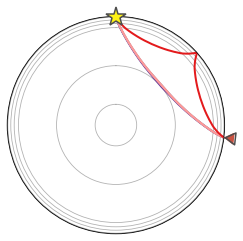

In [9]:
# visualize the ray paths
ray_paths.plot_rays();

In [10]:
# calculate the distance between the event and detection
distance = locations2degrees(lat1=event_dict["lat"], long1=event_dict["lon"], 
                             lat2=ANMO.latitude, long2=ANMO.longitude)

print("{} degrees.".format(round(distance, 2)))

96.6 degrees.


We can now download waveform data for the event from each model using the syngine client function [get_waveforms](https://docs.obspy.org/packages/autogen/obspy.clients.syngine.client.Client.get_waveforms.html). This function is essentially the same as [obspy.clients.fdsn.client.Client.get_waveforms](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html) so you will likely recognize the format.

In [59]:
# select the component we want to model
component = "Z"

# set the sampling rate, only upsampling is allowed so must be equal to or larger than the instruments'
sample_rate = 0.05

# create an empty dictionary to store the results from each model
data = {}

# loop through the 9 available models
for model in models.keys():
    
    print("Processing {}...".format(model))
    
    # some of the models can fail for an unknown reason (related to the time interval?)
    try:
    
        # download the data for each model into the dictionary
        data[model] = client.get_waveforms(model=model, network=network, 
                                           station=station, components=component, 
                                           dt=sample_rate, eventid=event_id,
                                           starttime=starttime, endtime=endtime)
    # print the error if we hit one
    except Exception as error:
        print("Error in {}:".format(model),  error)

Processing ak135f_5s...
Processing prem_a_2s...
Processing prem_i_2s...
Processing ak135f_2s...
Processing prem_a_10s...
Processing iasp91_2s...
Processing prem_a_20s...
Processing prem_a_5s...
Processing ak135f_1s...


Time to do some plotting. Prepare yourself for a lot of matplotlib fun.

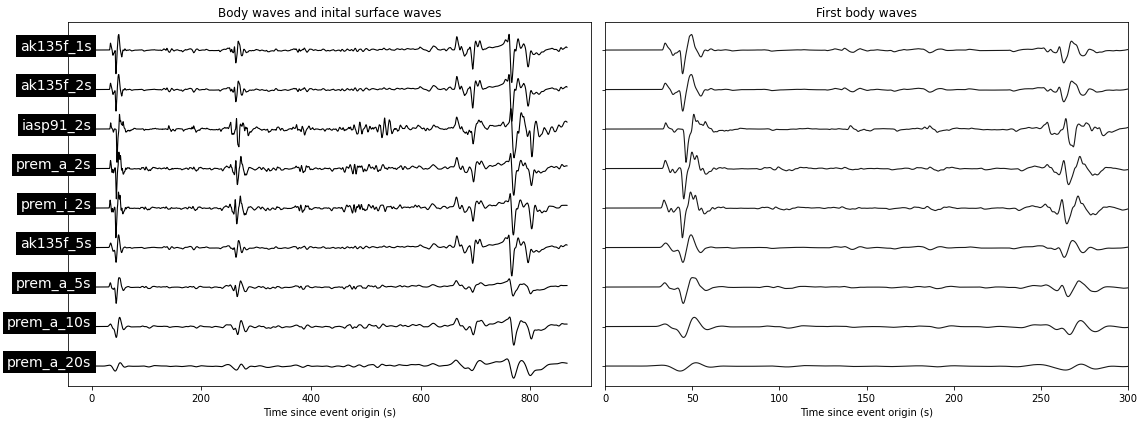

In [91]:
# set up the figure
fig = plt.figure(figsize=(16, 6), tight_layout=True)

# add our two subplots, this is the least gross way I know of
ax = fig.subplots(nrows=1, ncols=2)

# scale factor for the traces
factor = 5E2

# loop through our models
for index, model in enumerate(sorted(data.keys(), key=lambda x: (int(x.split("_")[-1][:-1]), x))):
    
    # get the trace from the stored downloaded model data
    tr = data[model][0]
    
    # get the current position for the trace to be plotted
    pos = len(data) - index - 1
    
    # plot the traces for each model
    ax[0].plot(tr.times(), tr.data * factor + pos, color="k", lw=1.1)
    ax[1].plot(tr.times(), tr.data * factor + pos, color="0.1", lw=1.1)
    
    
    # we need one line for each model
    ax[0].set_yticks(list(range(len(data))))
    ax[1].set_yticks(list(range(len(data))))
    
    # set the labels to be here
    ax[0].set_yticklabels([""] * len(data))
    ax[1].set_yticklabels([""] * len(data))
    
    # scale the y axis slightly so we get a tight view
    ax[0].set_ylim(-0.5, 8.7)
    ax[1].set_ylim(-0.5, 8.7)
    
    # set labels
    ax[0].set_xlabel("Time since event origin (s)")
    ax[0].set_title("Body waves and inital surface waves")
    ax[1].set_xlabel("Time since event origin (s)")
    ax[1].set_title("First body waves")

    # zoom in on the first body waves
    ax[1].set_xlim(0, 300)
    
    # label the models
    ax[0].text(0, pos, model, color="white",
             bbox=dict(facecolor="black", edgecolor="None"),
             ha="right", fontsize=14)

    

# save and display the figure
plt.savefig("compare_models.png", dpi=300, facecolor="white")
plt.show()